## Notebook Navigation:
1. Visualization and EDA <br>
    1. Background
    2. Problem Statement
    3. Data Import
    4. Data Overview
    5. Exploratory Data Analysis
2. **Preprocessing, Modeling and Evaluation**
    1. [Data Cleaning](#data-cleaning)
    2. [Imputation](#imputing-null-values)
    3. [Modeling and Evaluation](#modeling-and-evaluation)

In [221]:
#importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import OneHotEncoder,RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
%matplotlib inline
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [222]:
#import the data
train_df = pd.read_csv('../data/train.csv')
X = train_df.drop(columns='SalePrice')
y = train_df['SalePrice']

### Train Test Split Training Set

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.2) #to make sure no data leakage

### Data Cleaning
> We will be doing some clean up:
1. Standardizing the column header
2. Dropped those with >80% null values
3. Dropped those categorical features with univariate data >85%
4. Dropped those irrelevant features that are redundant
    - Garage cars  is basically referring to garage area but in terms of cars, hence, we will remove garage car column
    - Year Built, Year Remod, Garage Year Built are related to each other and will be represented by making a new House Age column
5. Making transformation on quality related features that are represented in scale from Poor to Excellent quality to numerical values that we can transformed

In [224]:
#for training set
def clean_up(df):
    #standardizing the columns
    df.columns=df.columns.str.lower().str.replace(' ','_')

    #lot_shape
    lot_shape_dict = {
        'Reg':0,
        'IR1':1,
        'IR2':2,
        'IR3':3,
    }
    df['lot_shape']=df['lot_shape'].map(lot_shape_dict) 

    #year
    df['house_age'] = df['yr_sold']-df['year_built']
    
    #remodelling
    df['is_remod'] = np.where(df['year_built']!=df['year_remod/add'],1,0)
    #ext quality
    qual_dict = {
        'Ex':5,
        'Gd':4,
        'TA':3,
        'Fa':2,
        'Po':1,
        'NA':0,
    }
    df['exter_qual'] = df['exter_qual'].map(qual_dict)
    
    #ext cond
    df['exter_cond'] = df['exter_cond'].map(qual_dict)

    #basement quality
    df['bsmt_qual'] = df['bsmt_qual'].map(qual_dict)

    #basement condition
    df['bsmt_cond'] = df['bsmt_cond'].map(qual_dict)

    #heating quality
    df['heating_qc'] = df['heating_qc'].map(qual_dict)

    #kitchecn quality
    df['kitchen_qual'] = df['kitchen_qual'].map(qual_dict)
    
    #fireplace quality
    df['fireplace_qu'] = df['fireplace_qu'].map(qual_dict)

    #pool cond
    df['pool_qc']=df['pool_qc'].map(qual_dict)
    
    #bsmt_expo
    df['bsmt_exposure']=df['bsmt_exposure'].map(qual_dict)

    #fence quality
    fence_qual_dict = {
        'GdPrv':4,
        'MnPrv':3,
        'GdWo':2,
        'MnWw':1,
        'NA':0
    }
    df['fence_qual'] = df['fence'].map(fence_qual_dict)
    
    #drop irrelevant columns
    irrelevant_cols = ['id','pid','year_built','garage_yr_blt','year_remod/add','garage_cars']
    df.drop(columns=irrelevant_cols,inplace=True,axis=1)
    
    #dropping those with null values more than 80%
    null_abv_80 = ['alley', 'pool_qc', 'fence', 'misc_feature']
    df.drop(columns=null_abv_80,inplace=True,axis=1)

    #dropping univariate columns more than 85%
    univariate_col = [
        'street','utilities','land_slope','condition_2','roof_matl',
        'bsmt_cond','heating','central_air','electrical','functional',
        'garage_qual','garage_cond','paved_drive',
    ]
    df.drop(columns=univariate_col,inplace=True,axis=1)
    return df

In [225]:
X_train = clean_up(X_train)
X_test = clean_up(X_test) 

### Imputing Null Values 
> Null values can't be processed in our model so we will impute with Simple Imputer. Assuming that those with null values mean that they have no such feature. Thefore, we will impute 0 to numerical features and NA to categorical features

In [226]:
def cat_feature(df):
    return df.select_dtypes(include="object").columns.tolist()
def num_feature(df):
    return df.select_dtypes(exclude="object").columns.tolist()
    
num_imp = SimpleImputer(strategy = 'constant', fill_value = 0, copy=True)
cat_imp = SimpleImputer(strategy = 'constant', fill_value = 'NA', copy=True)

### One Hot Encoding for Categorical Features and Scaling for Numerical Features
> One Hot Encoding is used to tranform our categorical features to 1 and 0

In [227]:
categorical_features = cat_feature(X_train)
numerical_features = num_feature(X_train)
ohe = OneHotEncoder(handle_unknown="ignore")
rs = RobustScaler()
#for numerical feature, we will impute then do Robust Scaling. 
#This scaler is chosen as it scales data to the quantile range/ where most of the data lying at
num_pipe = make_pipeline(num_imp,rs) 
cat_pipe = make_pipeline(cat_imp, ohe) 

In [228]:
full_prepare = make_column_transformer(
    (num_pipe, numerical_features),
    (cat_pipe, categorical_features),
    remainder="passthrough" # in this case there is no remainder
    )

In [229]:
#both in array form
X_train_prepared = full_prepare.fit_transform(X_train)
X_test_prepared = full_prepare.transform(X_test) 

In [230]:
num_columns=full_prepare.transformers_[0][2]
cat_columns_ohe = full_prepare.named_transformers_['pipeline-2'].named_steps['onehotencoder'].get_feature_names_out().tolist()
X_train_prepared_df= pd.DataFrame(X_train_prepared,columns= num_columns + cat_columns_ohe)

In [231]:
X_train_prepared_df.head()

,ms_subclass,lot_frontage,lot_area,lot_shape,overall_qual,overall_cond,mas_vnr_area,exter_qual,exter_cond,bsmt_qual,bsmt_exposure,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating_qc,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,fireplaces,fireplace_qu,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,house_age,is_remod,fence_qual,x0_A (agr),x0_C (all),x0_FV,x0_RH,x0_RL,x0_RM,x1_Bnk,x1_HLS,x1_Low,x1_Lvl,x2_Corner,x2_CulDSac,x2_FR2,x2_FR3,x2_Inside,x3_Blmngtn,x3_Blueste,x3_BrDale,x3_BrkSide,x3_ClearCr,x3_CollgCr,x3_Crawfor,x3_Edwards,x3_Gilbert,x3_Greens,x3_GrnHill,x3_IDOTRR,x3_Landmrk,x3_MeadowV,x3_Mitchel,x3_NAmes,x3_NPkVill,x3_NWAmes,x3_NoRidge,x3_NridgHt,x3_OldTown,x3_SWISU,x3_Sawyer,x3_SawyerW,x3_Somerst,x3_StoneBr,x3_Timber,x3_Veenker,x4_Artery,x4_Feedr,x4_Norm,x4_PosA,x4_PosN,x4_RRAe,x4_RRAn,x4_RRNe,x4_RRNn,x5_1Fam,x5_2fmCon,x5_Duplex,x5_Twnhs,x5_TwnhsE,x6_1.5Fin,x6_1.5Unf,x6_1Story,x6_2.5Fin,x6_2.5Unf,x6_2Story,x6_SFoyer,x6_SLvl,x7_Flat,x7_Gable,x7_Gambrel,x7_Hip,x7_Mansard,x7_Shed,x8_AsbShng,x8_AsphShn,x8_BrkComm,x8_BrkFace,x8_CBlock,x8_CemntBd,x8_HdBoard,x8_ImStucc,x8_MetalSd,x8_Plywood,x8_Stone,x8_Stucco,x8_VinylSd,x8_Wd Sdng,x8_WdShing,x9_AsbShng,x9_AsphShn,x9_Brk Cmn,x9_BrkFace,x9_CBlock,x9_CmentBd,x9_HdBoard,x9_ImStucc,x9_MetalSd,x9_Plywood,x9_Stone,x9_Stucco,x9_VinylSd,x9_Wd Sdng,x9_Wd Shng,x10_BrkCmn,x10_BrkFace,x10_NA,x10_None,x10_Stone,x11_BrkTil,x11_CBlock,x11_PConc,x11_Slab,x11_Stone,x11_Wood,x12_ALQ,x12_BLQ,x12_GLQ,x12_LwQ,x12_NA,x12_Rec,x12_Unf,x13_ALQ,x13_BLQ,x13_GLQ,x13_LwQ,x13_NA,x13_Rec,x13_Unf,x14_2Types,x14_Attchd,x14_Basment,x14_BuiltIn,x14_CarPort,x14_Detchd,x14_NA,x15_Fin,x15_NA,x15_RFn,x15_Unf,x16_COD,x16_CWD,x16_Con,x16_ConLD,x16_ConLI,x16_ConLw,x16_New,x16_Oth,x16_WD
0,1.4,-0.444444,-0.630578,1.0,0.0,0.0,1.50000,1.0,0.0,0.0,0.0,0.624157,0.0,0.092530,0.684461,0.0,0.501650,0.000000,0.0,-0.139051,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.75,0.015326,1.142857,0.121429,0.0,0.0,0.0,0.0,0.0,0.50,0.5,-0.613757,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.6,1.305556,1.177211,0.0,1.0,0.0,2.34375,1.0,0.0,0.0,0.0,-0.504049,0.0,2.491511,1.784557,-0.5,1.661480,0.000000,0.0,0.885096,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.5,0.0,0.75,1.590038,1.875000,0.250000,0.0,0.0,0.0,0.0,0.0,0.25,-0.5,-0.677249,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.6,-1.750000,1.604592,1.0,0.0,1.0,0.00000,0.0,0.0,0.0,4.0,1.045209,0.0,-0.630730,0.467112,-1.0,0.497878,0.000000,0.0,-0.142381,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.183908,8.476190,-0.392857,0.0,0.0,0.0,0.0,0.0,0.75,-0.5,-0.063492,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,

## Modeling and Evaluation
In order to tackle this, we will start by defining our Null Model. Then, we will have four different models to see how we can improve our model:
1. Ordinary Linear Regression Model
2. Lasso Regression Model
3. Ridge Regression Model
4. ElasticNet Regression Model

### The Null Model

In [232]:
y_mean = train_df['SalePrice'].mean()
df = train_df['SalePrice']
train_df.shape

(2051, 81)

In [233]:
np.sqrt(((train_df['SalePrice']-y_mean)**2).sum()/train_df.shape[0]) #RMSE for baseline

79239.33504161824

In [234]:
#function to calculate rmse for evaluation
def rmse(model,x,y):
    y_pred = model.predict(x)
    rmse = np.sqrt(mean_squared_error(y,y_pred))
    return rmse

### Ordinary Linear Regression

In [288]:
lr= LinearRegression()
model_1_pipe = make_pipeline(full_prepare,lr)
model_1_pipe.fit(X_train,y_train);

In [289]:
train1_score = model_1_pipe.score(X_train,y_train)
test1_score = model_1_pipe.score(X_test,y_test)
print(f'Training Score for Linear Regression: {train1_score}; Test Score: {test1_score}')

Training Score for Linear Regression: 0.9015206671057947; Test Score: 0.8876246343502003


In [290]:
#RMSE score
rmse(model_1_pipe,X_train,y_train)

25032.671537283375

(0.0, 600000.0)

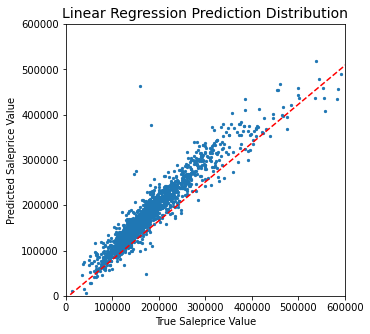

In [292]:
y_pred = model_1_pipe.predict(X_train)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_train, y_pred,s=5)
ax.set_title('Linear Regression Prediction Distribution',fontsize=14)
ax.set_xlabel('True Saleprice Value',fontsize=10)
ax.set_ylabel('Predicted Saleprice Value',fontsize=10)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="r")
ax.set_xlim(0,600000)
ax.set_ylim(0,600000)

In [238]:
#check if y log transformed generate better score
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [239]:
model_1_pipe.fit(X_train,y_train_log);
model_1_pipe.score(X_train,y_train_log)

0.9209203870524468

In [240]:
model_1_pipe.score(X_test,y_test_log)

0.8727919034840121

In [241]:
rmse(model_1_pipe,X_train,y_train_log)

0.11467574292659659

### Lasso

In [242]:
#hyperparameter tuning to find the best alpha

lasso = Lasso(max_iter=100000) #10000 steps we'll take in the gradient descent before giving up
lasso_pipe = make_pipeline(full_prepare,lasso)
lasso_params = {'lasso__alpha':[0.001,0.01,1,10,20,50,100]}

gs_lasso = GridSearchCV(
    estimator = lasso_pipe,
    param_grid = lasso_params,
    cv = 10,
    n_jobs = -1,
    return_train_score = True,
    verbose=1,
    scoring = 'r2'


In [243]:
gs_lasso.fit(X_train, y_train);
gs_lasso.best_params_

Fitting 10 folds for each of 7 candidates, totalling 70 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.463e+11, tolerance: 9.304e+08
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.905e+11, tolerance: 9.368e+08
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

{'lasso__alpha': 50}

In [244]:
lasso_df = pd.DataFrame(gs_lasso.cv_results_)
lasso_df.loc[:,['rank_test_score','mean_train_score','mean_test_score','params']]

,rank_test_score,mean_train_score,mean_test_score,params
0,6,0.904115,0.829475,{'lasso__alpha': 0.001}
1,7,0.904115,0.829427,{'lasso__alpha': 0.01}
2,5,0.904105,0.830079,{'lasso__alpha': 1}
3,4,0.903647,0.833827,{'lasso__alpha': 10}
4,2,0.902934,0.835400,{'lasso__alpha': 20}
5,1,0.900398,0.836274,{'lasso__alpha': 50}
6,3,0.895759,0.834661,{'lasso__alpha': 100}


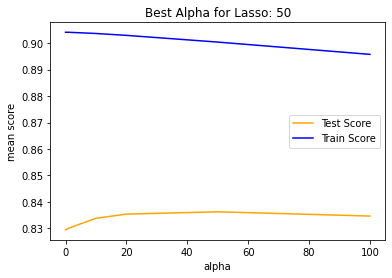

In [245]:
a= lasso_df['params'].tolist()
alphas = []
for i in a:
    alphas.append(i['lasso__alpha'])
sns.lineplot(x=alphas,y=lasso_df['mean_test_score'],color='orange',label='Test Score')
sns.lineplot(x=alphas,y=lasso_df['mean_train_score'],color='blue',label='Train Score')
plt.xlabel('alpha')
plt.ylabel('mean score')
plt.title('Best Alpha for Lasso: 50');


In [246]:
train2_score = gs_lasso.score(X_train,y_train)
test2_score = gs_lasso.score(X_test,y_test)
print(f'Training Score for Lasso: {train2_score}; Test Score: {test2_score}')

Training Score for Lasso: 0.8980298212411515; Test Score: 0.8960323696764286


In [247]:
#RMSE for lasso
rmse(gs_lasso,X_train,y_train)

25472.480719665804

In [248]:
gs_lasso.fit(X_train, y_train_log);
gs_lasso.best_params_ 

Fitting 10 folds for each of 7 candidates, totalling 70 fits


{'lasso__alpha': 0.001}

In [285]:
train2_score_log = gs_lasso.score(X_train,y_train_log)
test2_score_log = gs_lasso.score(X_test,y_test_log)
print(f'Training Score for Lasso: {train2_score_log}; Test Score: {test2_score_log}')

Training Score for Lasso: 0.8984604456658749; Test Score: 0.88531455352971


In [287]:
y_pred = gs_lasso.predict(X_train)
y_pred_lof_lasso_trf = np.exp(y_pred)
np.sqrt(((y_train-y_pred_lof_lasso_trf)**2).sum()/y_train.shape[0]) #RMSE 

28318.38210091793

In [251]:
#creating pipeline for further use
lasso2 = Lasso(alpha=50,max_iter=100000) #100000 steps we'll take in the gradient descent before giving up
model_2_pipe = make_pipeline(full_prepare,lasso2)
model_2_pipe.fit(X_train,y_train_log);

### Ridge

In [252]:
ridge = Ridge(max_iter=100000) #100000 steps we'll take in the gradient descent before giving up
ridge_pipe = make_pipeline(full_prepare,ridge)
ridge_params = {'ridge__alpha':[0.001,0.01,0.1,1,10,20,50,100]}

gs_ridge = GridSearchCV(
    estimator = ridge_pipe,
    param_grid = ridge_params,
    cv = 10,
    n_jobs = -1,
    return_train_score = True,
    scoring = 'r2'
)
gs_ridge.fit(X_train, y_train);
gs_ridge.best_params_

{'ridge__alpha': 10}

In [253]:
ridge_df = pd.DataFrame(gs_ridge.cv_results_)
ridge_df.loc[:,['rank_test_score','mean_train_score','mean_test_score','params']]

,rank_test_score,mean_train_score,mean_test_score,params
0,6,0.904115,0.829232,{'ridge__alpha': 0.001}
1,5,0.904115,0.829346,{'ridge__alpha': 0.01}
2,4,0.904093,0.830186,{'ridge__alpha': 0.1}
3,2,0.903435,0.832861,{'ridge__alpha': 1}
4,1,0.898170,0.833875,{'ridge__alpha': 10}
5,3,0.894424,0.832439,{'ridge__alpha': 20}
6,7,0.887085,0.828831,{'ridge__alpha': 50}
7,8,0.879774,0.825309,{'ridge__alpha': 100}


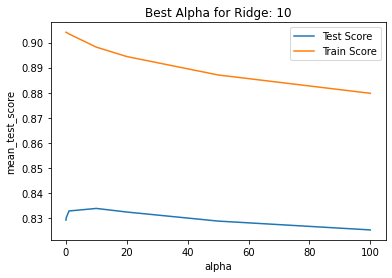

In [254]:
r = ridge_df['params'].tolist()
r_alphas = []
for i in r:
    r_alphas.append(i['ridge__alpha'])
sns.lineplot(x=r_alphas,y=ridge_df['mean_test_score'],label='Test Score')
sns.lineplot(x=r_alphas,y=ridge_df['mean_train_score'],label='Train Score')
plt.xlabel('alpha')
plt.title('Best Alpha for Ridge: 10');


In [255]:
train3_score = gs_ridge.score(X_train,y_train)
test3_score = gs_ridge.score(X_test,y_test)
print(f'Training Score for Linear Regression: {train3_score}; Test Score: {test3_score}')

Training Score for Linear Regression: 0.8962290550659963; Test Score: 0.8991398524510423


In [256]:
#RMSE for Ridge Regression
rmse(gs_ridge,X_train,y_train)

25696.41500117413

In [257]:
#making model
ridge = Ridge(alpha=10,max_iter=10000) #10000 steps we'll take in the gradient descent before giving up
model_3_pipe = make_pipeline(full_prepare,ridge)
model_3_pipe.fit(X_train, y_train);

### ElasticNet

In [258]:
enet = ElasticNet() #10000 steps we'll take in the gradient descent before giving up
enet_params = {
    'alpha': [0.01,0.1,0.5,1],
    'l1_ratio':[0,0.1,0.5,0.9,1]
}

gs_enet = GridSearchCV(
    estimator = enet,
    param_grid = enet_params,
    cv = 10,
    n_jobs = -1,
    return_train_score = True,
    scoring = 'r2'
)
gs_enet.fit(X_train_prepared, y_train);
gs_enet.best_params_

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.409e+11, tolerance: 9.347e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.474e+11, tolerance: 9.601e+08 Linear regression models with null weight for the l1 regularization term are mor

{'alpha': 0.01, 'l1_ratio': 0.5}

In [259]:
train4_score = gs_enet.score(X_train_prepared,y_train)
test4_score = gs_enet.score(X_test_prepared,y_test)
print(f'Training Score for Linear Regression: {train4_score}; Test Score: {test4_score}')

Training Score for Linear Regression: 0.8969839765520554; Test Score: 0.898641539459146


In [260]:
rmse(gs_enet,X_train_prepared,y_train)

25602.77517893609

### Model Performance Evaluation
Our baseline model (calculating by the saleprice mean) RMSE is *$79,239*. Our objective is to find a model with better RMSE. The lower the RMSE, the closer our prediction value to the true value. 

The four models were fitted to our training data. R<sup>2</sup> or Coefficient of Determination is a statistical measure that explains the proportion of variability that can be explained by the independent varibales.

Our objective is to **have lower RMSE and better R<sup>2</sup> score.**

All of our model is definitely a better predictor then only predicting based on the population saleprice mean.

The best training score is Ordinary Linear Regression, but, if we look at the score of test set, we can observe the indication of overfitting. Overfitting means our model have high variance where it is unable to generalize that well to our test set. One of the reason is due to the potential collinear features.

Regularization is one of the way to reduce overfitting. It is a process to introduce a penalty term (alpha) to our features coefficient. We can see that regularized model able to generate better test score. However, the lowest RMSE is still held by Ordinary Linear Regression model ($23,650).

|No.|Model|R<sup>2</sup>  Training|R<sup>2</sup> Test| RMSE |
|---|---|---|---|---|
|1|Ordinary Linear Regression|90.15|88.75|25032|
|1a|Ordinary Linear Regression (Log Transformed Target)|92.10|87.28|23650|
|2|Lasso (alpha = 50)|89.80|89.60|25472|
|2|Lasso (alpha = 0.001,Log Transformed Target)|89.85|88.53|28318|
|3|Ridge (alpha = 10)|89.62|89.91|25696|
|4|ElasticNet(alpha = 0.01, l1-ratio = 0.5)|89.70|89.86|25602|

As there is a slight overfitting on the Ordinary Linear Regression, we will go ahead with both Lasso with alpha of 50 and Linear Regression with Log Transformed Target as the RMSE is the lowest of all.

### Model Evaluation - Target is not Transformed

In [261]:
model_2_pipe_coef = make_pipeline(lasso2)
model_2_pipe_coef.fit(X_train_prepared_df,y_train); #need to get the columns
lasso_coef = model_2_pipe.named_steps['lasso'].coef_.tolist()
lasso_col =X_train_prepared_df.columns.tolist()

In [262]:
pd.DataFrame({'feat':lasso_col,'coef':lasso_coef},columns=['feat','coef']).sort_values(by='coef',ascending=True)

,feat,coef
112,x7_Mansard,-23605.431340
65,x3_Edwards,-16088.994468
180,x16_COD,-13386.008498
125,x8_Stucco,-12656.154762
144,x10_BrkCmn,-12579.217802
49,x1_Bnk,-10818.848911
99,x5_TwnhsE,-8893.118387
91,x4_RRAe,-8528.005952
140,x9_Stucco,-8407.810965
188,x16_WD,-8245.586407


(0.0, 600000.0)

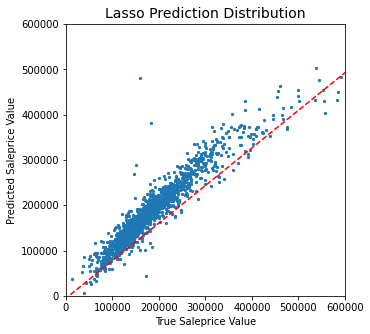

In [263]:
#evaluating on training prediction price vs true price
y_pred = model_2_pipe_coef.predict(X_train_prepared_df)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_train, y_pred,s=5)
ax.set_title('Lasso Prediction Distribution',fontsize=14)
ax.set_xlabel('True Saleprice Value',fontsize=10)
ax.set_ylabel('Predicted Saleprice Value',fontsize=10)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="r")
ax.set_xlim(0,600000)
ax.set_ylim(0,600000)

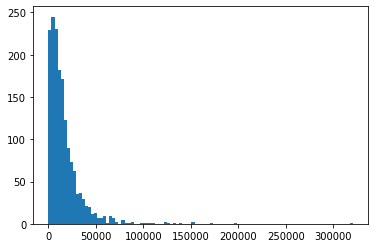

In [264]:
#for the y not log transformed
residual=np.sqrt((y_pred-y_train)**2)
plt.hist(residual, bins = 100);

# Model Evaluation - Target is Transformed in Ordinary Linear Regression

In [280]:
model_1_pipe.fit(X_train,y_train_log);

In [281]:
y_pred_log = model_1_pipe.predict(X_train)

In [282]:
y_pred_log_trf = np.exp(y_pred_log)

In [283]:
y_train.shape[0]

1640

In [284]:
np.sqrt(((y_train-y_pred_log_trf)**2).sum()/y_train.shape[0]) #RMSE 

23650.235733594924

(0.0, 600000.0)

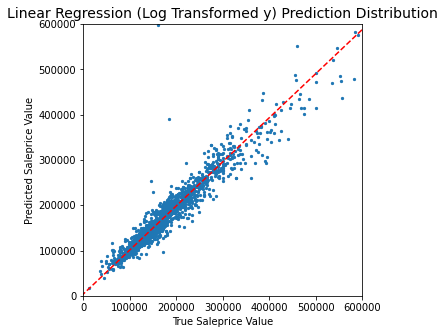

In [268]:
#evaluating on training prediction price vs true price
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_train, y_pred_log_trf,s=5)
ax.set_title('Linear Regression (Log Transformed y) Prediction Distribution',fontsize=14)
ax.set_xlabel('True Saleprice Value',fontsize=10)
ax.set_ylabel('Predicted Saleprice Value',fontsize=10)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="r")
ax.set_xlim(0,600000)
ax.set_ylim(0,600000)

(-10000.0, 100000.0)

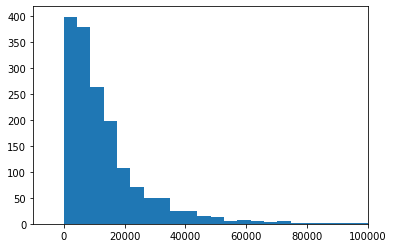

In [269]:
#for the y not log transformed
residual_log=np.sqrt((y_pred_log_trf-y_train)**2)
plt.hist(residual_log, bins = 100);
plt.xlim(-10000,100000)

### Summary Overview

Our prediction is linearly distributed for both models that we have chosen which are Linear Regression (log y transforemed) and the Lasso Regression Model with Alpha of 50. 

**In the Linear Regression model with y value log transformed, we can see that the prediction is more linearly correlated, which means the model performed better.** Therefore, it is no surprise that our submission for RMSE value is also lower using this Linear Regression compared to Lasso and **it is our best model**.

Although Lasso might not perform as well as the Linear Regression Model. We can deduce few things from the lasso coefficient. External material is not a really significant features that influence the saleprice. Therefore, if homeowners would like to increase their house saleprice, rather than spending on a very expensive external material, they can first focus on **renovating the house to improve Overall Quality and General Living Area size.** If these qualities have been satisfied, then we can look at **basement full bathroom, kitchen quality and to add fireplace feature if you don't have any.**

Aside from that, we observe there are certain neighbourhoods that are not really preferred such as Edwards, Old Town, Iowa DOT and Rail Road. These areas have quite old buildings and some of the buildings in Edwards has planned to be repurposed to be City of Ames Park. Therefore, homebuyers can probably **avoid these areas and look for a rather newer or remodelled houses with better overall quality in GreenHill, Stone Brook, Northridge area.**



### Submission-Lasso

In [270]:
test = pd.read_csv('../data/test.csv')
test_cleaned = clean_up(test)

In [271]:
y_pred = model_2_pipe.predict(test_cleaned)#using Lasso with alpha =50

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


In [272]:
#REFRESH 
test = pd.read_csv('../data/test.csv')
submission2 = test[['Id']]
submission2['SalePrice'] = y_pred

/var/folders/tg/8mpzp58s7wd9h25zt2bffqd00000gn/T/ipykernel_8680/4025665011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission2['SalePrice'] = y_pred


In [273]:
submission2.to_csv('Submission2.csv',index=None)

For lasso with alpha =50
- Public Score 32551.87436
- Private Score 22981.34329

### Submission-Linear Regression (Log Transformed y)

In [274]:
y_pred = model_1_pipe.predict(test_cleaned) #using ordinary linear regression

In [275]:
y_pred_log_trf = np.exp(y_pred)

In [276]:
test = pd.read_csv('../data/test.csv')
submission3 = test[['Id']]
submission3['SalePrice'] = y_pred_log_trf

/var/folders/tg/8mpzp58s7wd9h25zt2bffqd00000gn/T/ipykernel_8680/140385958.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission3['SalePrice'] = y_pred_log_trf


In [277]:
submission3.to_csv('Submission3.csv',index=None)

For linear regression
- Public Score 27096.25499
- Private Score 21744.89945